In [93]:
import pandas as pd
import os
from glob import glob
import json
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn import svm
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

set top level directory where gradings are found

In [2]:
gradings_top_dir = "C:\\Users\\Johnathan Young\\Box\\AIDEV\\03. Internal AI Projects\\4. Improved registration\\data"

walk through the directories looking for "registration_*_metrics_gradings.json" or "metrics_gradings.csv"
dump either in a pandas data frame with the following columns:
registration dir|target image|registered image|NMI|NCC|MSE|grading

In [3]:
gradings_added = 0
for root, dirs, files in os.walk(gradings_top_dir, topdown=True):
    for dir in dirs:
        
        # set the directory we're looking in
        gradings_dir = os.path.join(gradings_top_dir, root, dir)
        
        # if we find single .csv containing all gradings
        if len(glob(os.path.join(gradings_dir, "metrics_gradings.csv"))) > 0:
            
            # read in the csv and add a column containing the directory, and drop unneeded Unnamed column
            dir_gradings_DF = pd.read_csv((os.path.join(gradings_dir, "metrics_gradings.csv")))
            dir_gradings_DF['registrations dir'] = gradings_dir
            
            # if this is the first gradings we find, make the DF the new overall DF. If not, concatenate
            if gradings_added == 0:
                gradings_DF = dir_gradings_DF
            else :
                gradings_DF = pd.concat([gradings_DF, dir_gradings_DF])
                
            gradings_DF.drop(columns=['Unnamed: 0'], inplace=True) 
            gradings_added = gradings_added + 1          
                        
        # if we find one json per grading
        elif len(glob(os.path.join(gradings_top_dir, root, dir, "registration*metrics_gradings.json"))) > 0:
            
            dir_gradings_list = []
            
            # read each one in and add to list
            for json_filename in glob(os.path.join(gradings_top_dir, root, dir, "registration*metrics_gradings.json")):
                
                with open(os.path.join(gradings_dir,json_filename)) as json_file:
                    gradings_dict = json.load(json_file)
                json_file.close
                dir_gradings_list.append(gradings_dict)
            
            # make dicts into dataframe and add a column containing the directory
            dir_gradings_DF = pd.DataFrame(dir_gradings_list)
            dir_gradings_DF['registrations dir'] = gradings_dir
            
            # rename to match names from .csv gradings
            dir_gradings_DF.columns = ['target image file', 'registered image file', 'NMI',
       'NCC', 'MSE', 'grading', 'registrations dir']
                
            # if this is the first gradings we find, make the DF the new overall DF. If not, concatenate
            if gradings_added == 0:
                gradings_DF = dir_gradings_DF
            else :
                gradings_DF = pd.concat([gradings_DF, dir_gradings_DF])
            gradings_added = gradings_added + 1
                


filter out gradings of -1 (grading rejected)

In [4]:
gradings_DF.reindex()
gradings_DF = gradings_DF[gradings_DF['grading']>0]

scatter plots for all 3 metrics vs gradings, together with correlations

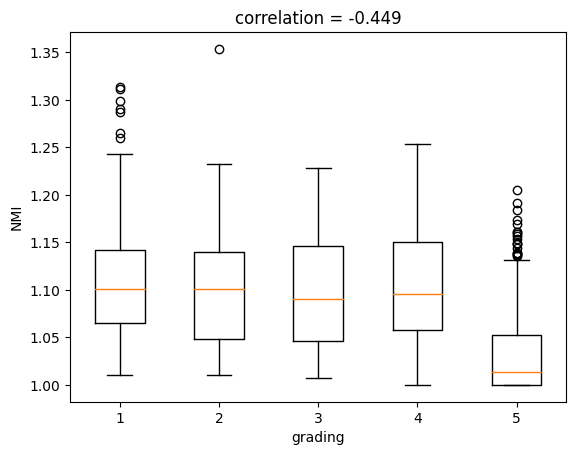

AUC = 0.721091



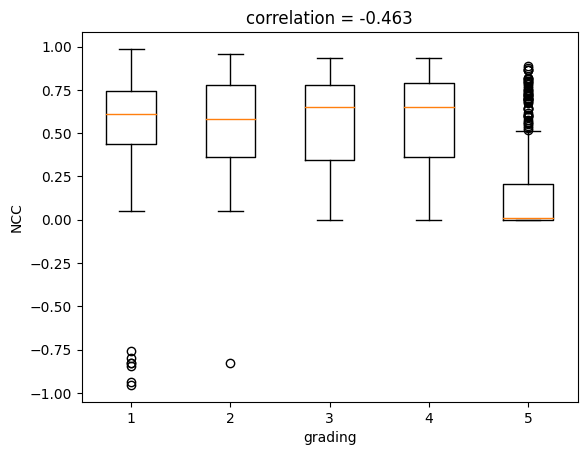

AUC = 0.714742



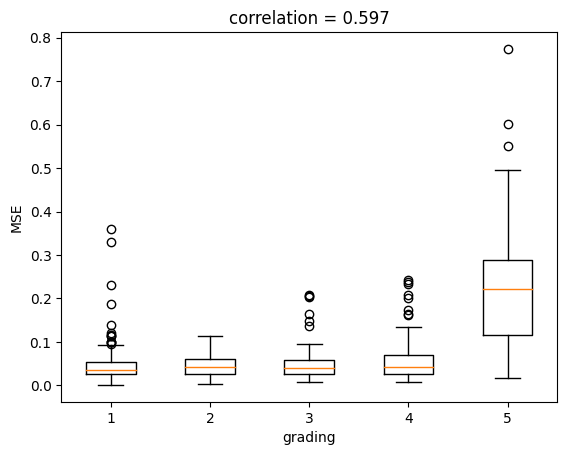

AUC = 0.238318


In [92]:
gradings = gradings_DF['grading'].values
metrics = ['NMI', 'NCC', 'MSE']
passfail = gradings <=2
for metric in metrics :
    
    # extract metric data and calculate correlation with gradings
    metric_data = gradings_DF[metric].values
    corr = pearsonr(metric_data, gradings).statistic
   # plt.scatter(metric_data, gradings)
    #plt.xlabel(metric)
    #plt.ylabel('grading')
    #plt.title("correlation = {:.3f}".format(corr))
    #plt.show()
    
    print()
    
    # boxplots
    plt.boxplot([metric_data[gradings==1], metric_data[gradings==2], metric_data[gradings==3], metric_data[gradings==4], metric_data[gradings==5]])
    plt.xlabel('grading')
    plt.ylabel(metric)
    plt.title("correlation = {:.3f}".format(corr))
    plt.show()
    
    
    # calculate AUCs between good (grading <=2) and bad (grading > 2) of the metric
    AUC = roc_auc_score(passfail, metric_data)
    print('AUC = {:3f}'.format(AUC))

try a linear SVM for classifying pass/fail

In [44]:
scaler = StandardScaler()
metrics_data = gradings_DF[['NMI', 'NCC', 'MSE']].values
metrics_data_scaled = scaler.fit_transform(metrics_data)
X, y = shuffle(metrics_data_scaled, passfail)


clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=10)
scores

array([0.66942149, 0.69421488, 0.70247934, 0.6446281 , 0.73553719,
       0.66942149, 0.675     , 0.71666667, 0.7       , 0.59166667])

look in detail at results

In [77]:
preds = []
decision_vals = []
gt = []
accs = []
clf = svm.SVC(kernel='linear', C=1, random_state=42, class_weight = 'balanced')
kf = KFold(n_splits=10, random_state=None, shuffle=True)
for train_index , test_index in kf.split(metrics_data):
    X_train , X_test = metrics_data[train_index,:],metrics_data[test_index,:]
    y_train , y_test = passfail[train_index], passfail[test_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf.fit(X_train, y_train)
    preds.append(clf.predict(X_test))
    decision_vals.append(clf.decision_function(X_test))
    gt.append(y_test)
    accs.append(accuracy_score(y_test, clf.predict(X_test)))
preds = np.concatenate(preds)
decision_vals = np.concatenate(decision_vals)
gt = np.concatenate(gt)

Results - acc score and confusion matrix 

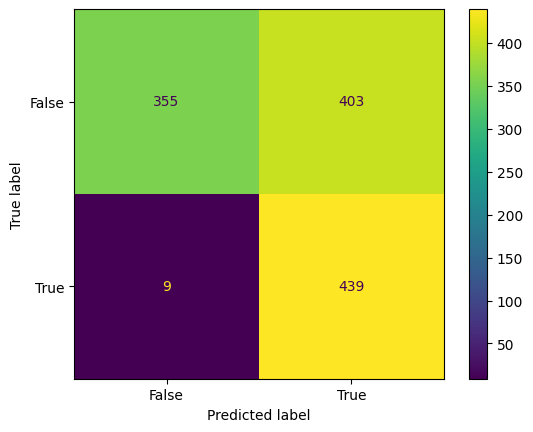

In [96]:
acc = accuracy_score(gt, preds)
acc
ConfusionMatrixDisplay.from_predictions(gt, preds)
plt.show()

In [99]:
AUC = roc_auc_score(gt, decision_vals)
AUC

0.7713378722201281

array([ True, False, False, ...,  True, False,  True])